### Lasso Regression Model w/Poly Features
#### Data 200 - Graduate Student Final Project
#### Team Members: Erin Jones, Filipe Santos

After investigating the model's performance further, we decided it was time to remove some features and try a different approach as the RFECV approach was getting tripped up by the multicollinearity across features. Lasso regression is much more robust to multicollinearity, so we decided to give it a try. 

Additionally, this model was modified to:
* Remove the timezone calculation as it takes a ton of time
* Remove time of day calculation as it was assigning numerical value to a cyclical variable and relied on the timezone calculation
* Remove haversine column as it was assigning value to a position on earth likely already captured by altitude
* Remove log transform, instead creating polynomial features and using min-max scaling
* Remove outliers from all variables
* Add Lasso regression without RFECV, as it is more robust to multicollinearity
* Add Min Max Scaling to variables
* Custom reversable scaling for the heart rate measurment

In [170]:
# IMPORTS
import pickle
import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error

### Load sample + Duplicate Subsamples Used For Model 1

In [171]:
# open pickle file to work with 
with open('./data/500_user.pkl', 'rb') as file:
    # dump into dictionary object
    users_dict = pickle.load(file)

# ensure load worked properly
for user, df in users_dict.items():
    print(len(users_dict))
    display(df.head())
    break

500


,since_begin,since_last,tar_derived_speed,heart_rate,distance,sport,tar_heart_rate,derived_speed,id,timestamp,altitude,gender,time_elapsed,longitude,latitude,userId,workout_n
0,-14.805054,-0.01158,0.000000,8.532873,-4.372304,run,179,-7.082944,649100510,1451317040,0.038282,male,-0.122568,25.276541,54.750948,1413935,35004
1,-14.805054,-0.01158,9.925434,8.532873,-2.989371,run,179,-3.134742,649100510,1451317046,0.023704,male,-0.122300,25.276727,54.750845,1413935,35004
2,-14.805054,-0.01158,11.857894,8.532873,-2.995481,run,179,-2.366035,649100510,1451317051,0.009125,male,-0.122077,25.276908,54.750740,1413935,35004
3,-14.805054,-0.01158,10.866049,8.321098,-3.110645,run,178,-2.760578,649100510,1451317056,0.009125,male,-0.121854,25.277104,54.750665,1413935,35004
4,-14.805054,-0.01158,13.632061,6.626896,-2.472918,run,170,-1.660296,649100510,1451317062,-0.005454,male,-0.121587,25.277388,54.750543,1413935,35004


In [172]:
# create a list of subsamples identical to those used for model 1
random.seed(42)
num_samples = 10
keys_per_sample = 10
all_keys = list(users_dict.keys())

subsamples = []

for _ in range(num_samples):
    sampled_keys = random.sample(all_keys, keys_per_sample)
    subsample_dict = {key: users_dict[key] for key in sampled_keys}
    subsamples.append(subsample_dict)

    # remove the sampled keys from all_keys to ensure uniqueness in subsequent samples
    all_keys = [key for key in all_keys if key not in sampled_keys]

subsample_a = subsamples[0]
subsample_b = subsamples[1]
subsample_c = subsamples[2]
subsample_d = subsamples[3]
subsample_e = subsamples[4]
subsample_f = subsamples[5]
subsample_g = subsamples[6]
subsample_h = subsamples[7]
subsample_i = subsamples[8]
subsample_j = subsamples[9]

### Helper Functions

Many of the helper functions below are identical to those used in model 1, the only new ones are:

- min_max_scale_columns -> uses scikit learn's min max scaler to scale all columns except the target variable (as it is hard to reverse this scaling)
- create_polynomial_features -> uses scikit learn's polynomial features to generated polynomial features up to degree 4 as part of the pipeline
- scale_target_variable (a custom scaling function using the training set mean and standard deviation) -> scales the target variable, returning the constants used to scale as well as the scaled variable such that it can be reversed at a later date
- inverse_transform (reverse of the previous function) -> takes the constants produced by scale_target_variable to reverse the scaling and allow for appropriate calculation of rmse

In [184]:
def remove_outliers(data, variables, upper=None, lower=None):
    df = data.copy()
    
    for variable in variables:
        mean = df[variable].mean()
        std = df[variable].std()

        if upper:
            upper_fence = upper
        else:
            upper_fence = mean + (3 * std)

        if lower:
            lower_fence = lower
        else:
            lower_fence = mean - (3 * std)

        df = df[(df[variable] >= lower_fence) & (df[variable] <= upper_fence)]
    
    return df

def add_mins_elapsed(data):

    def cumulative_by_group(group_df):

        # calc the running difference
        group_df['diff'] = (group_df['timestamp'].diff())/60
        # fill row 1
        group_df['diff'].iloc[0] = 0
        # calculate the cumulative sum
        group_df['elapsed'] = group_df['diff'].cumsum()

        return group_df

    grouped = data.groupby('workout_n')
    data = grouped.apply(cumulative_by_group)
    data.reset_index(drop=True, inplace=True)

    return data

def ohe_categorical(data, column_name):
    """
    One-hot-encodes categorical variable. New columns are of the form "'col_name'_NUMBER".
    We drop the first column to allow the intercept to remain in the regression model while
    avoiding multicollinearity
    """
    if len(data[column_name]) == 0:
        return data
    else:
        enc = OneHotEncoder(drop='first')
        o_h_e = (enc.fit_transform(data[[column_name]])).toarray()
        one_hot_encoded_df = (pd.DataFrame(o_h_e, columns=enc.get_feature_names_out([column_name]))).set_index(data.index)
        data = data.merge(one_hot_encoded_df, left_index=True, right_index=True)
    return data

def min_max_scale_columns(df, columns):
    """
    Applies Min-Max scaling to specified columns of a DataFrame.

    Args:
    df (pd.DataFrame): The DataFrame to be scaled.
    columns (list): List of column names to be scaled.

    Returns:
    pd.DataFrame: The DataFrame with specified columns scaled.
    """
    scaler = MinMaxScaler()

    for col in columns:
        if col in df.columns:
            # Reshape data for scaling
            data = df[col].values.reshape(-1, 1)
            # Scale the data and replace in the DataFrame
            df[col] = scaler.fit_transform(data)
        else:
            print(f"Column {col} not found in DataFrame.")

    return df

def create_polynomial_features(df, degree=4, include_bias=False):
    """
    Generates a new DataFrame with polynomial features.

    Args:
    df (pd.DataFrame): Original DataFrame.
    degree (int): The degree of the polynomial features. Default is 3.
    include_bias (bool): If True, include a bias column (all 1s). Default is False.

    Returns:
    pd.DataFrame: A new DataFrame with original and polynomial features.
    """
    poly = PolynomialFeatures(degree=degree, include_bias=include_bias)
    poly_features = poly.fit_transform(df)

    # Generate feature names
    feature_names = poly.get_feature_names(input_features=df.columns)

    # Create a DataFrame with new polynomial features
    df_poly = pd.DataFrame(poly_features, columns=feature_names)

    return df_poly

def scale_target_variable(target_var_series):
    # custom scaling
    scale_mean = target_var_series.mean()
    scale_std = target_var_series.std()
    target_custom_scaled = (target_var_series - scale_mean) / scale_std
    return scale_mean, scale_std, target_custom_scaled

def inverse_transform(target_var_scaled, std, mean):
    # reversing the custom scaling
    target_original_scale = ((pd.Series(target_var_scaled)) * std) + mean
    target_os = target_original_scale.to_numpy()
    return target_os

### Instantiate Lasso Functions and Processing Pipe

The below run_lasso_cv performs in a similar role to rfecv, utilizing TimeSeriesSplit cross validation to find the optimal alpha value for the lasso regression model given a training set.

Otherwise, the pipeline for model 2 is quite similar to that of model 1 in structure. The large differences are:
* the removal of a lot of funny business with the timestamps that didn't seem fruitfull and produced a lot of multicollinearity
* the handling of all outliers for numerical variables where it makes sense ('tar_derived_speed', 'distance', 'altitude', and 'tar_heart_rate')
* also, the scaling of all of the variables listed in the previous bullet as lack of scaling can negatively impact the lasso regression. This will also help to handle some of the skewness and other undesirable characteristics seen in eda_2.ipynb

In [185]:
# helper function used in the process_data_pipe to determine the best suited alpha for the lasso model
def run_lasso_cv(X_train, y_train):
    tscv = TimeSeriesSplit(n_splits=5) 
    lasso_cv = LassoCV(cv=tscv, random_state=42)  
    lasso_cv.fit(X_train, y_train)
    best_alpha = lasso_cv.alpha_
    return best_alpha

In [186]:
# Data pipeline processing, as pulled from Project 2
def process_data_pipe(df, pipeline_functions, prediction_col=None):
    data = df.copy()
    # specify columns to drop from raw data out the gate
    data.fillna(method='bfill', inplace=True)
    drop_cols = ['since_begin', 'since_last', 'heart_rate', 'derived_speed', 'id', 'gender', 'time_elapsed', 'userId', 'latitude', 'longitude']
    data.drop(columns=drop_cols, inplace=True)
    
    # run pipeline functions
    for function, positional_arguments, keyword_arguments in pipeline_functions:
        if keyword_arguments and (not positional_arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (positional_arguments):
            data = data.pipe(function, *positional_arguments)
        else:
            data = data.pipe(function)

    # create x_y split
    if prediction_col:
        # df = data.dropna()
        # drop interim columns added prior to running feature selector
        scale_mean, scale_std, hr_scaled = scale_target_variable(data['tar_heart_rate'])
        data['scaled_hr'] = hr_scaled
        X = data.drop(columns=[prediction_col, 'timestamp', 'tar_heart_rate', 'sport'])
        y = data.loc[:, prediction_col]
        alpha = run_lasso_cv(X, y)
        
        return X, y, alpha, scale_mean, scale_std
    
    # pull x for the given set
    else:
        X = data
        return X

# Ordering of the final steps for the final pipeline -- helping to differentiate between training/test set 
def process_data_final(data, is_test_set=False):
    
    df = data.copy()
    processing_all = [
        (remove_outliers, None, {'variables': ['tar_derived_speed', 'distance', 'altitude']}),
        (add_mins_elapsed, None, None),
        (ohe_categorical, None, {'column_name': 'sport'}), 
        (min_max_scale_columns, None, {'columns':['tar_derived_speed', 'distance', 'altitude']})
        ]
    
    # Training set
    if not is_test_set:
        processing_training = [
            (remove_outliers, None, {'variables': ['tar_heart_rate'], 'upper': 200, 'lower': 40})
            ]
        processing_steps = processing_training + processing_all
        X, y, alpha, scale_mean, scale_std = process_data_pipe(df, pipeline_functions=processing_steps, prediction_col='scaled_hr')
        return X, y, alpha, scale_mean, scale_std
    
    # Test set
    else:
        processing_steps = processing_all
        X = process_data_pipe(df, pipeline_functions=processing_steps, prediction_col=None)
        return X

### Instantiate Desired Error Metric

In order to effectively compare our second model with our first, we use the RMSE again. However, the actual and predicted values from the tests are retained and as such the MAE can be pulled if needed.

In [187]:
# Evaluation Metrics

def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values.
    Input:
      predicted (1D array): Vector of predicted/fitted values
      actual (1D array): Vector of actual values
    Output:
      A float, the RMSE value.
    """
    return np.sqrt(np.mean((actual - predicted)**2))

In [188]:
# formula that instantiates and runs the model
def split_and_run(dataframe, user_id):

    # dictionaries for storing data
    train_dict = {}
    test_dict = {}

    X, y, suggested_alpha, scale_mean, scale_std = process_data_final(dataframe)

    # shuffle = False to preserve time series
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
    y_train_proper = inverse_transform(y_train, scale_std, scale_mean)
    y_test_proper = inverse_transform(y_test, scale_std, scale_mean)

    # first ohe is dropped to prevent multi-collinearity and allow for intercept
    model = Lasso(alpha=suggested_alpha)

    # fit model
    model.fit(X_train, y_train)

    # compute fitted (based on training set) and predicted (based on test set)
    y_fitted = model.predict(X_train)
    y_fitted_proper = inverse_transform(y_fitted, scale_std, scale_mean)
    y_predicted = model.predict(X_test)
    y_predicted_proper = inverse_transform(y_predicted, scale_std, scale_mean)
    
    
    # calculate error metric
    fitted_rmse = rmse(y_fitted_proper, y_train_proper)
    predicted_rmse = rmse(y_predicted_proper, y_test_proper)

    # # add results to a dictionary indexed by user for easy access and transformation into dataframes
    # # later, but low memory use when running this cell
    train_dict[user_id] = [fitted_rmse, X_train, y_train_proper, y_fitted_proper] 
    test_dict[user_id] = [predicted_rmse, X_test, y_test_proper, y_predicted_proper]

    return train_dict, test_dict

In [189]:
# Instantiate dictionaries for storing overall data
users_train = {}
users_test = {}

In [190]:
# Create and collect results for the ten users part of subsample a
for user, data in subsample_a.items():
    train_results, test_results = split_and_run(data, user)
    users_train.update(train_results)
    users_test.update(test_results) 

# Create and collect results for the ten users part of subsample b
for user, data in subsample_b.items():
    train_results, test_results = split_and_run(data, user)
    users_train.update(train_results)
    users_test.update(test_results) 

# Create and collect results for the ten users part of subsample c
for user, data in subsample_c.items():
    train_results, test_results = split_and_run(data, user)
    users_train.update(train_results)
    users_test.update(test_results) 

# Create and collect results for the ten users part of subsample d
for user, data in subsample_d.items():
    train_results, test_results = split_and_run(data, user)
    users_train.update(train_results)
    users_test.update(test_results) 

# Create and collect results for the ten users part of subsample e
for user, data in subsample_e.items():
    train_results, test_results = split_and_run(data, user)
    users_train.update(train_results)
    users_test.update(test_results) 

In [191]:
# Create a new dictionary so the joining doesn't take as long for the below
users_train_2 = {}
users_test_2 = {}

for user, data in subsample_f.items():
    train_results, test_results = split_and_run(data, user)
    users_train_2.update(train_results)
    users_test_2.update(test_results)

for user, data in subsample_g.items():
    train_results, test_results = split_and_run(data, user)
    users_train_2.update(train_results)
    users_test_2.update(test_results)    

for user, data in subsample_h.items():
    train_results, test_results = split_and_run(data, user)
    users_train_2.update(train_results)
    users_test_2.update(test_results)  

for user, data in subsample_i.items():
    train_results, test_results = split_and_run(data, user)
    users_train_2.update(train_results)
    users_test_2.update(test_results)  

for user, data in subsample_j.items():
    train_results, test_results = split_and_run(data, user)
    users_train_2.update(train_results)
    users_test_2.update(test_results)  

In [192]:
# merge dictionaries
users_train.update(users_train_2)
users_test.update(users_test_2)

# dump results to pickle
with open('mega_train_lasso.pkl', 'wb') as file:
    # Use pickle.dump to write the dictionary to the file
    pickle.dump(users_train, file)
with open('mega_test_lasso.pkl', 'wb') as file:
    # Use pickle.dump to write the dictionary to the file
    pickle.dump(users_test, file)

In [193]:
# create df for ease of manipulation and graphing for rmse
data_train = [(key, *value) for key, value in users_train.items()]
df_train = pd.DataFrame(data_train, columns=['user_id', 'rmse', 'x_train', 'y_train', 'y_fitted'])

data_test = [(key, *value) for key, value in users_test.items()]
df_test = pd.DataFrame(data_test, columns=['user_id', 'rmse', 'x_test', 'y_test', 'y_predicted'])

In [194]:
print("The fitted results (training set) for running Model 2 on our sample of 100 users are as follows:")
display(df_train['rmse'].describe())
print("-----------------------------------------------------------")
print("\nThe predicted results (testing set) for running Model 2 on our sample of 100 users are as follows:")
display(df_test['rmse'].describe())
print("-----------------------------------------------------------")

The fitted results (training set) for running Model 2 on our sample of 100 users are as follows:


count    100.000000
mean      15.754358
std        3.643825
min        6.089046
25%       13.406535
50%       15.844197
75%       18.129641
max       23.569762
Name: rmse, dtype: float64

-----------------------------------------------------------

The predicted results (testing set) for running Model 2 on our sample of 100 users are as follows:


count    100.000000
mean      17.001074
std        5.218085
min        2.842513
25%       14.094210
50%       15.910782
75%       19.607264
max       43.812227
Name: rmse, dtype: float64

-----------------------------------------------------------


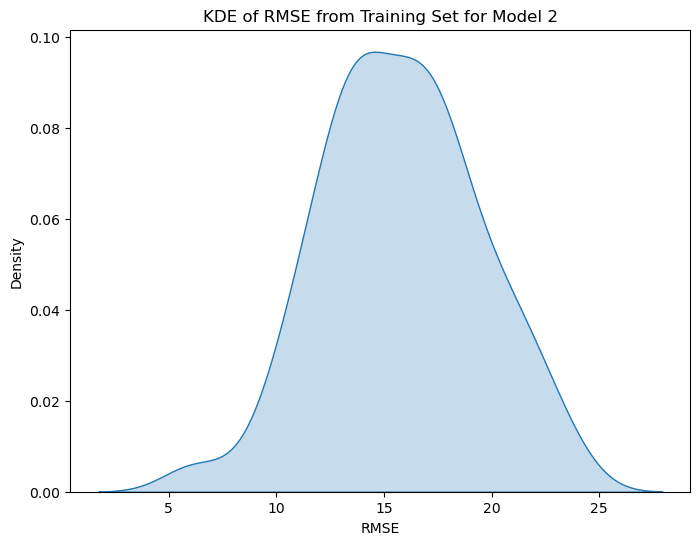

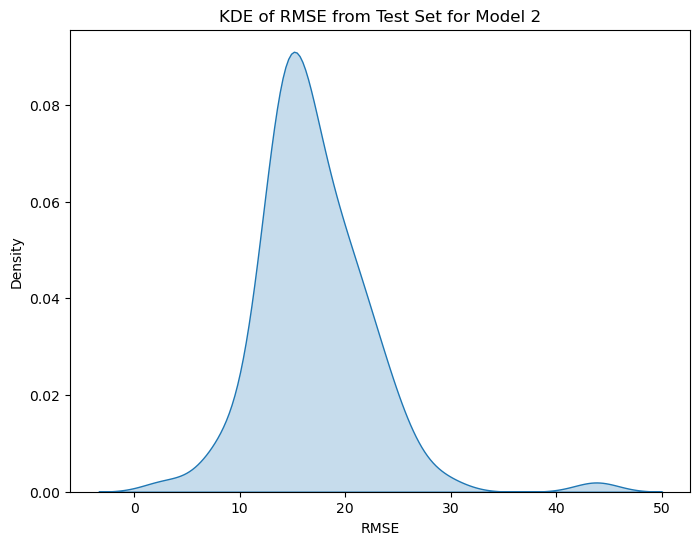

In [195]:
# plot kde for training rmse
plt.figure(figsize=(8, 6))
sns.kdeplot(df_train['rmse'], fill=True, label='RMSE Training Set')
plt.xlabel('RMSE')
plt.ylabel('Density')
plt.title('KDE of RMSE from Training Set for Model 2')
plt.show()

# plot kde for testing rmse
plt.figure(figsize=(8, 6))
sns.kdeplot(df_test['rmse'], fill=True, label='RMSE Testing Set')
plt.xlabel('RMSE')
plt.ylabel('Density')
plt.title('KDE of RMSE from Test Set for Model 2')
plt.show()

In [196]:
def get_users_with_xtreme_results(your_dict):
    # sort dictionary items by RMSE
    sorted_items = sorted(your_dict.items(), key=lambda x: x[1][0])

    # extract three (lowest) and three (highest) keys
    lowest_keys = [item[0] for item in sorted_items[:3]]
    highest_keys = [item[0] for item in sorted_items[-3:]]

    return lowest_keys, highest_keys

lowest, highest = get_users_with_xtreme_results(users_test)
print("Model 2 performs as follows on the test set:")
print(f"\nTop Three:")
print(f"\n\t* {lowest[0]} - RMSE {users_test[lowest[0]][0]}")
print(f"\n\t* {lowest[1]} - RMSE {users_test[lowest[1]][0]}")
print(f"\n\t* {lowest[2]} - RMSE {users_test[lowest[2]][0]}")
print(f"\nBottom Three:")
print(f"\n\t* {highest[0]} - RMSE {users_test[highest[0]][0]}")
print(f"\n\t* {highest[1]} - RMSE {users_test[highest[1]][0]}")
print(f"\n\t* {highest[2]} - RMSE {users_test[highest[2]][0]}")

Model 2 performs as follows on the test set:

Top Three:

	* 9359950 - RMSE 2.84251312845796

	* 8484809 - RMSE 6.604061380414558

	* 10808479 - RMSE 8.38228845286529

Bottom Three:

	* 1860957 - RMSE 26.90301289467547

	* 9937628 - RMSE 29.640363595864127

	* 1663599 - RMSE 43.81222733016359
